In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

from probe_gen.probes.wandb_interface import load_probe_eval_dict_by_dict
from probe_gen.config import TRAIN_AND_TEST_SETS, HYPERPARAMETERS

In [3]:
def plot_perplexity_vs_performance(perplexities, performance_data, 
                                 colors=None, 
                                 figsize=(10, 6),
                                 y_limits=(0.8, 1.0),
                                 title="Perplexity vs Performance by Behavior",
                                 x_label="Perplexity (log scale)",
                                 y_label="Performance on On-Policy Test Set",
                                 show_plot=True,
                                 print_stats=True):
    """
    Create a scatter plot with trend lines showing the relationship between perplexity and performance.
    
    Parameters:
    -----------
    perplexities : dict
        Dictionary where keys are behavior names and values are lists of perplexity values
    performance_data : dict
        Dictionary where keys are behavior names and values are lists of performance values
    colors : list, optional
        List of colors for each behavior. If None, uses default colors.
    figsize : tuple, optional
        Figure size as (width, height). Default is (10, 6).
    y_limits : tuple, optional
        Y-axis limits as (min, max). Default is (0.8, 1.0).
    title : str, optional
        Plot title. Default includes average correlation.
    x_label : str, optional
        X-axis label. Default is "Perplexity (log scale)".
    y_label : str, optional
        Y-axis label. Default is "Performance on On-Policy Test Set".
    show_plot : bool, optional
        Whether to display the plot. Default is True.
    print_stats : bool, optional
        Whether to print correlation statistics. Default is True.
    
    Returns:
    --------
    dict
        Dictionary containing:
        - 'avg_correlation': Average correlation across behaviors
        - 'individual_correlations': List of individual behavior correlations
        - 'behavior_names': List of behavior names
        - 'avg_slope': Average slope of trend lines
        - 'avg_intercept': Average intercept of trend lines
    """
    
    # Default colors
    if colors is None:
        colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']
    
    behavior_names = list(perplexities.keys())
    
    # Ensure we have enough colors
    while len(colors) < len(behavior_names):
        colors.extend(colors)
    
    # Create the plot
    plt.figure(figsize=figsize)
    
    # Store trend coefficients for averaging
    individual_slopes = []
    individual_intercepts = []
    individual_correlations = []
    
    # Plot each behavior
    for i, behavior in enumerate(behavior_names):
        x = perplexities[behavior]
        y = performance_data[behavior]
        
        # Plot scatter points with lower opacity
        plt.scatter(x, y, color=colors[i], label=f'{behavior} (points)', 
                   s=60, alpha=0.4)
        
        # Calculate correlation and trend line for this behavior
        r, p_value = pearsonr(x, y)
        individual_correlations.append(r)
        
        if print_stats:
            print(f"{behavior}: r = {r:.3f}, p = {p_value:.3f}")
        
        # Fit trend line in log space for this behavior
        log_x = np.log10(x)
        z = np.polyfit(log_x, y, 1)  # Linear fit in log space
        individual_slopes.append(z[0])
        individual_intercepts.append(z[1])
        p_behavior = np.poly1d(z)
        
        # Create smooth line for this behavior's trend
        x_range = np.logspace(np.log10(min(x)), np.log10(max(x)), 100)
        log_x_range = np.log10(x_range)
        y_trend = p_behavior(log_x_range)
        
        # Plot the correlation line for this behavior with lower opacity
        plt.plot(x_range, y_trend, color=colors[i], linestyle='-', linewidth=2,
                alpha=0.4, label=f'{behavior} trend (r={r:.3f})')
    
    # Calculate average trend line from individual behavior trends
    avg_slope = np.mean(individual_slopes)
    avg_intercept = np.mean(individual_intercepts)
    avg_correlation = np.mean(individual_correlations)
    
    # Flatten all data for range calculations
    all_perplexities = [val for behavior_vals in perplexities.values() for val in behavior_vals]
    all_performances = [val for behavior_vals in performance_data.values() for val in behavior_vals]
    
    # Create smooth line for the average trend
    x_smooth = np.logspace(np.log10(min(all_perplexities)), np.log10(max(all_perplexities)), 100)
    log_x_smooth = np.log10(x_smooth)
    y_summary = avg_slope * log_x_smooth + avg_intercept
    plt.plot(x_smooth, y_summary, 'black', linestyle='--', linewidth=3,
            label=f'Summary trend (avg r={avg_correlation:.3f})', alpha=0.9)
    
    # Formatting
    plt.ylim(*y_limits)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    
    # Update title to include average correlation
    if "Average Correlation" not in title:
        title = f"{title}\nAverage Correlation: r = {avg_correlation:.3f}"
    
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Use log scale for x-axis due to wide range in perplexities
    plt.xscale('log')
    plt.tight_layout()
    
    if show_plot:
        plt.show()
    
    # Print summary statistics
    if print_stats:
        print(f"\nSummary correlation (average of behaviors): r = {avg_correlation:.3f}")
        print(f"Individual correlations: {[f'{r:.3f}' for r in individual_correlations]}")
        print(f"Number of behaviors: {len(behavior_names)}")
    
    # Return analysis results
    return {
        'avg_correlation': avg_correlation,
        'individual_correlations': individual_correlations,
        'behavior_names': behavior_names,
        'avg_slope': avg_slope,
        'avg_intercept': avg_intercept
    }

In [4]:
def get_on_policy_test_sets(train_and_test_sets, 
                          hyperparameters,
                          activations_model="llama_3b",
                          metric="roc_auc",
                          probe_type="mean",
                          state_filter="finished",
                          behaviors=None,
                          return_on_policy_only=True,
                          verbose=True):
    """
    Evaluate probe results across different behaviors and datasets.
    
    Parameters:
    -----------
    train_and_test_sets : dict
        Dictionary with behavior names as keys, containing 'train' and 'test' dataset lists
    hyperparameters : dict
        Dictionary with dataset names as keys, containing hyperparameter configurations
    load_probe_eval_dict_by_dict : function
        Function to load probe evaluation results given a configuration dictionary
    activations_model : str, optional
        Model name for activations. Default is "llama_3b".
    metric : str, optional
        Metric to extract from results. Default is "roc_auc".
    probe_type : str, optional
        Type of probe to use. Default is "mean".
    state_filter : str, optional
        Filter for run state. Default is "finished".
    behaviors : list, optional
        List of behaviors to evaluate. If None, uses all behaviors from train_and_test_sets.
    return_on_policy_only : bool, optional
        If True, returns only on-policy results (diagonal). If False, returns full results tables.
    verbose : bool, optional
        Whether to print progress and results. Default is True.
    
    Returns:
    --------
    dict
        If return_on_policy_only is True: Dictionary with behavior names as keys and 
        on-policy test results as values (1D arrays).
        If return_on_policy_only is False: Dictionary with behavior names as keys and 
        full results tables as values (2D arrays).
    """
    
    # Use all behaviors if none specified
    if behaviors is None:
        behaviors = list(train_and_test_sets.keys())
    
    results_dict = {}
    
    for behavior in behaviors:
        if verbose:
            print(f"\nProcessing behavior: {behavior}")
        
        # Get dataset names for this behavior
        dataset_names = train_and_test_sets[behavior]["train"]
        test_dataset_names = train_and_test_sets[behavior]["test"]
        
        if verbose:
            print(f"Train datasets: {dataset_names}")
            print(f"Test datasets: {test_dataset_names}")
        
        # Extract hyperparameters for each dataset
        try:
            layer_list = [hyperparameters[key]['layer'] for key in dataset_names]
            use_bias_list = [hyperparameters[key]['use_bias'] for key in dataset_names]
            normalize_list = [hyperparameters[key]['normalize'] for key in dataset_names]
            C_list = [hyperparameters[key]['C'] for key in dataset_names]
        except KeyError as e:
            print(f"Warning: Missing hyperparameters for key {e} in behavior {behavior}")
            continue
        
        # Initialize results table
        results_table = np.full((len(dataset_names), len(test_dataset_names)), -1, dtype=float)
        
        # Evaluate all train/test combinations
        for train_index in range(len(dataset_names)):
            for test_index in range(len(test_dataset_names)):
                
                # Build configuration dictionary
                config = {
                    "config.train_dataset": dataset_names[train_index],
                    "config.test_dataset": test_dataset_names[test_index],
                    "config.layer": layer_list[train_index],
                    "config.probe/type": probe_type,
                    "config.probe/use_bias": use_bias_list[train_index],
                    "config.probe/normalize": normalize_list[train_index],
                    "config.probe/C": C_list[train_index],
                    "config.activations_model": activations_model,
                    "state": state_filter,
                }
                
                try:
                    # Load results for this configuration
                    results = load_probe_eval_dict_by_dict(config)
                    
                    # Extract the specified metric
                    metric_value = results[metric]
                    results_table[train_index, test_index] = metric_value
                    
                    if verbose:
                        print(f"  {dataset_names[train_index]} -> {test_dataset_names[test_index]}: {metric_value:.4f}")
                        
                except Exception as e:
                    if verbose:
                        print(f"  Warning: Failed to load results for {dataset_names[train_index]} -> {test_dataset_names[test_index]}: {e}")
                    continue
        
        # Store results for this behavior
        if return_on_policy_only:
            # Extract on-policy results (diagonal - train and test on same dataset)
            results_dict[behavior] = results_table[:, 0]  # Assuming first test dataset corresponds to on-policy
        else:
            # Store full results table
            results_dict[behavior] = results_table
    
    return results_dict


In [9]:
on_policy_test_sets = get_on_policy_test_sets(TRAIN_AND_TEST_SETS, HYPERPARAMETERS)

on_policy_test_sets



Processing behavior: refusal
Train datasets: ['refusal_llama_3b_5k', 'refusal_llama_3b_prompted_5k', 'refusal_ministral_8b_5k']
Test datasets: ['refusal_llama_3b_1k', 'refusal_llama_3b_prompted_1k', 'refusal_ministral_8b_1k']
  refusal_llama_3b_5k -> refusal_llama_3b_1k: 0.9103
  refusal_llama_3b_5k -> refusal_llama_3b_prompted_1k: 0.9062
  refusal_llama_3b_5k -> refusal_ministral_8b_1k: 0.9150
  refusal_llama_3b_prompted_5k -> refusal_llama_3b_1k: 0.9120
  refusal_llama_3b_prompted_5k -> refusal_llama_3b_prompted_1k: 0.9244
  refusal_llama_3b_prompted_5k -> refusal_ministral_8b_1k: 0.9142
  refusal_ministral_8b_5k -> refusal_llama_3b_1k: 0.9099
  refusal_ministral_8b_5k -> refusal_llama_3b_prompted_1k: 0.8783
  refusal_ministral_8b_5k -> refusal_ministral_8b_1k: 0.9156

Processing behavior: lists
Train datasets: ['lists_llama_3b_5k', 'lists_llama_3b_prompted_5k', 'lists_qwen_3b_5k']
Test datasets: ['lists_llama_3b_1k', 'lists_llama_3b_prompted_1k', 'lists_qwen_3b_1k']
  lists_llama_3

{'refusal': array([0.910256, 0.911988, 0.90992 ]),
 'lists': array([0.969984, 0.966224, 0.968028]),
 'metaphors': array([0.942576, 0.931684, 0.941004]),
 'science': array([0.956548, 0.957968, 0.957288]),
 'sycophancy_short': array([0.920116, 0.917248, 0.815768]),
 'sycophancy': array([ 0.9221  ,  0.891516, -1.      ])}

In [5]:
# Load or get perplexity 

def remove_large_outliers(data):
    arr = np.array(data)
    # Calculate the 99th percentile (threshold for top 1%)
    threshold = np.percentile(arr, 99)
    # Keep only values below this threshold
    filtered_arr = arr[arr < threshold]

    return filtered_arr

from probe_gen.analysis import load_perplexities

model_name = 'llama_3b'

behaviours = ["refusal", "lists", "metaphors", "science", "sycophancy"]

perplexities = {} 

for behaviour in behaviours:
    dataset_names = TRAIN_AND_TEST_SETS[behaviour]["train"]
    perplexities_on = load_perplexities(behaviour, model_name, dataset_names[0].replace(behaviour, "").replace("_", "", 1) )
    perplexities_on_prompted = load_perplexities(behaviour, model_name, dataset_names[1].replace(behaviour, "").replace("_", "", 1) )
    perplexities_off = load_perplexities(behaviour, model_name, dataset_names[2].replace(behaviour, "").replace("_", "", 1))

    perplexities_on = remove_large_outliers(perplexities_on)
    perplexities_on_prompted = remove_large_outliers(perplexities_on_prompted)
    perplexities_off = remove_large_outliers(perplexities_off)

    perplexities_on_mean = np.mean(perplexities_on)
    perplexities_on_prompted_mean = np.mean(perplexities_on_prompted)
    perplexities_off_mean = np.mean(perplexities_off)

    perplexities[behaviour] = [perplexities_on_mean, perplexities_on_prompted_mean, perplexities_off_mean] 


wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: samdower to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


In [32]:
perplexities

{'refusal': [np.float64(3.787771259689331),
  np.float64(12757.517632628584),
  np.float64(60.10086087114811)],
 'lists': [np.float64(2.2299852377891543),
  np.float64(2.446009966158867),
  np.float64(5.813478327870369)],
 'metaphors': [np.float64(2.2564241428136826),
  np.float64(3.4723229056119918),
  np.float64(6.213809450268745)],
 'science': [np.float64(2.162458135509491),
  np.float64(2.500702361536026),
  np.float64(5.252705902743339)],
 'sycophancy': [np.float64(1.4030159186422826),
  np.float64(2.103278741568327),
  np.float64(2.053675216956595)]}

refusal: r = 0.456, p = 0.699
lists: r = -0.103, p = 0.934
metaphors: r = 0.067, p = 0.957
science: r = 0.125, p = 0.920
sycophancy: r = -0.453, p = 0.701


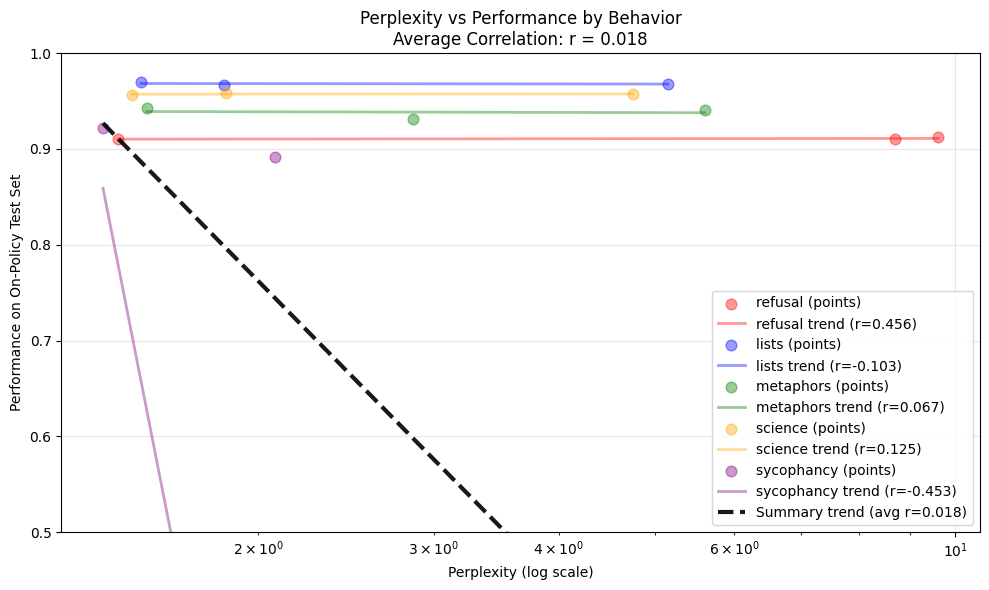


Summary correlation (average of behaviors): r = 0.018
Individual correlations: ['0.456', '-0.103', '0.067', '0.125', '-0.453']
Number of behaviors: 5


{'avg_correlation': np.float64(0.018390186810965336),
 'individual_correlations': [np.float64(0.4556298642692176),
  np.float64(-0.10342460706015802),
  np.float64(0.06718494822457494),
  np.float64(0.12547077374095839),
  np.float64(-0.4529100451197662)],
 'behavior_names': ['refusal', 'lists', 'metaphors', 'science', 'sycophancy'],
 'avg_slope': np.float64(-1.0574008739743441),
 'avg_intercept': np.float64(1.0801597821179574)}

In [10]:
#on_policy_test_sets["sycophancy"] = on_policy_test_sets["sycophancy_short"]
plot_perplexity_vs_performance(perplexities, on_policy_test_sets, y_limits=(0.5, 1.0))

# FAKE PLOT (for demonstration purposes)

In [11]:
# fake data
perplexities = {'refusal': [np.float64(3),
  np.float64(60),
  np.float64(500)],
 'lists': [np.float64(10),
  np.float64(80),
  np.float64(200)],
 'metaphors': [np.float64(20),
  np.float64(200),
  np.float64(1000)],
 'science': [np.float64(1),
  np.float64(100),
  np.float64(200)]}

on_policy_test_sets = {'refusal': [0.98, 0.7, 0.5],
 'lists': [0.98, 0.7, 0.5],
 'metaphors': [0.98, 0.7, 0.5],
 'science': [0.98, 0.7, 0.5]}


refusal: r = -0.871, p = 0.328
lists: r = -0.970, p = 0.157
metaphors: r = -0.902, p = 0.284
science: r = -0.995, p = 0.063


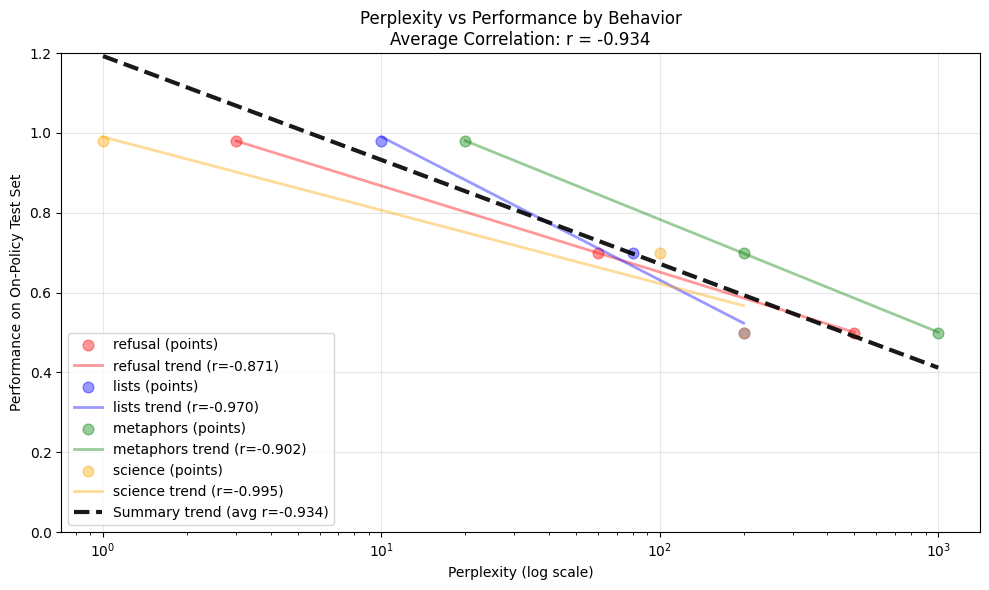


Summary correlation (average of behaviors): r = -0.934
Individual correlations: ['-0.871', '-0.970', '-0.902', '-0.995']
Number of behaviors: 4


{'avg_correlation': np.float64(-0.9343689990429087),
 'individual_correlations': [np.float64(-0.8705138220696921),
  np.float64(-0.9697209353273492),
  np.float64(-0.9021210424617543),
  np.float64(-0.9951201963128393)],
 'behavior_names': ['refusal', 'lists', 'metaphors', 'science'],
 'avg_slope': np.float64(-0.2602401911141732),
 'avg_intercept': np.float64(1.1926723619260748)}

In [13]:
plot_perplexity_vs_performance(perplexities, on_policy_test_sets, y_limits=(0, 1.2))